# Assembly algorithm

This script performs the assembly algorithm. It contains the following steps:

- Loading and cleaning read data and reference genome data
- Visualizing overlap between reads
- Collapsing the regions where there is empty data

# Load Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Reference Genome

Info: https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use

S3 nanopore directory:

s3cmd get --recursive s3://aretian-genomics/nanopore/

In [2]:
# Pull reference genome from S3
# !s3cmd get s3://aretian-genomics/nanopore/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# !gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# Index reference genome
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna

# Select chromosomes or regions
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna chr17 > chr17_selected.fa

## Extract Chromosome 17

Extract Chr17 from reference genome.

In [4]:
# Read in fasta file: remove line breaks and header
def read_fasta_genome(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

with open('../data/processed/chr17_selected.fa') as f: # update path if needed
    ref_genome = read_fasta_genome(f,'>chr17')

# See https://www.bioinformatics.org/sms/iupac.html for IUPAC nucleotide codes

print(f"Unique characters: {list(set(ref_genome))}") 

print(f"Selected chromosome from reference genome is {len(ref_genome)} BP long")

Unique characters: ['R', 'A', 'G', 'S', 'W', 'C', 'Y', 'K', 'T', 'N']
Selected chromosome from reference genome is 83257441 BP long


# Load Reads

Samtools view --> format of output: http://samtools.github.io/hts-specs/SAMv1.pdf

In [5]:
#!view -c bioliquid_chr17_pompe.bam
#!samtools view bioliquid_chr17_pompe.bam | head -n 500 > bioliquid_chr17_pompe_500reads.txt

# nanopore_reads = pd.read_csv('../data/processed/bioliquid_chr17_pompe_reads-old.csv', error_bad_lines=False, header=None)
# nanopore_reads = pd.read_csv('../data/processed/bioliquid_chr17_pompe_reads.csv', error_bad_lines=False, header=None)
nanopore_reads = pd.read_csv('../data/processed/bioliquid_chr17_pompe_reads-old.csv', error_bad_lines=False)

## Clean Reads

In [51]:
# Sort and get ID
nanopore_reads = nanopore_reads.sort_values(by='POS',ascending=True) # sort based on starting index of reads
nanopore_reads = nanopore_reads.reset_index()
nanopore_reads['ID'] = nanopore_reads.index
# Get columns of interest
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT','TLEN', 'SEQ', 'QUAL']]
# Drop missing values
nanopore_reads = nanopore_reads.loc[nanopore_reads['SEQ'] != '*'] # drop any rows without a proper nucleotide sequence
nanopore_reads = nanopore_reads.reset_index()

# Descriptive Statistics of Reads

In [52]:
# for ID in nanopore_reads.index:
#     print(f"Leftmost index --> {nanopore_reads.loc[ID,'POS']}, Read length --> {len(nanopore_reads.loc[ID,'SEQ'])}")

In [53]:
end_index = max(nanopore_reads['POS']) + len(nanopore_reads.loc[nanopore_reads['POS'].idxmax(),'SEQ'])
start_index = min(nanopore_reads['POS'])
index_range = end_index-start_index

read_overlap = np.zeros((len(nanopore_reads),index_range)) # empty matrix for reads

for ID in nanopore_reads.index:
#     print(f"Adding raad cover for read {ID+1}: Index-->{nanopore_reads.loc[ID,'POS']}, length-->{len(nanopore_reads.loc[ID,'SEQ'])}")
    start = nanopore_reads.loc[ID,'POS']-start_index
#     print(start)
    end = start+len(nanopore_reads.loc[ID,'SEQ'])
#     print(end)
    read_overlap[ID,start:end] = 1
    
summary = read_overlap.sum(axis=0)

overlap_df = pd.DataFrame(data=summary,index=range(start_index,end_index), columns=['overlap_count'])
overlap_df['position'] = overlap_df.index

## Plot read overlap

In [61]:
# len(overlap_df)
# i=1
# overlap_df.loc[i,'isempty']

In [62]:
overlap_df['isempty']=overlap_df['overlap_count']==0
win_length=10000
emptycount = 0
emptyregioncounter = 0

for i in overlap_df.index:
    
    if overlap_df.loc[i,'isempty']==False:
        emptycount = 0
        continue
        
    emptycount += 1
    
    if emptycount >= win_length:
        emptyregioncounter +=1
        
    if i%100000==0:
        print(f"Loop: {i}")

Loop: 23400000
Loop: 23800000
Loop: 23900000
Loop: 24100000
Loop: 24300000
Loop: 24400000
Loop: 24500000
Loop: 24600000
Loop: 25100000
Loop: 25700000
Loop: 26200000
Loop: 26900000


In [63]:
print(f"There are at most {emptyregioncounter} regions with lengths larger than {win_length}")

There are at most 787254 regions with lengths larger than 10000


Text(0, 0.5, '# Reads Overlapping')

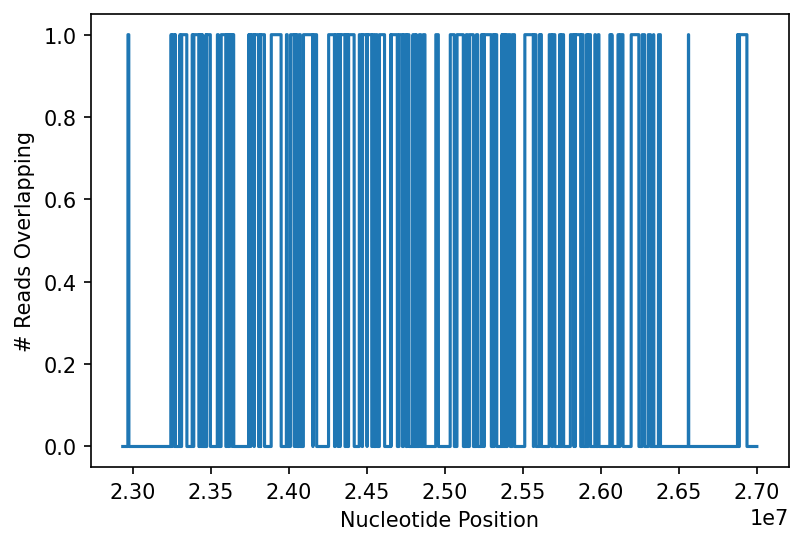

In [64]:
fig, ax = plt.subplots(dpi=150)
# plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
# plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
# plt.plot(overlap_df.loc[1000000:,'position'],overlap_df.loc[1000000:,'overlap_count'])
# plt.plot(overlap_df['position'],overlap_df['overlap_count'])
plt.plot(overlap_df['position'],overlap_df['isempty'])
plt.xlabel('Nucleotide Position')
plt.ylabel('# Reads Overlapping')

## Read Length and Position

In [65]:
# Check read length statistics
nanopore_reads['SEQ_LEN'] = nanopore_reads['SEQ'].apply(lambda x: len(x))
nanopore_reads['END_POS'] = nanopore_reads['POS']+nanopore_reads['SEQ_LEN']
print(f"Read length statistics:")
nanopore_reads['SEQ_LEN'].describe()

Read length statistics:


count     1080.000000
mean     11367.615741
std      10815.201656
min        100.000000
25%       2307.250000
50%       6254.000000
75%      18966.750000
max      32759.000000
Name: SEQ_LEN, dtype: float64

In [66]:
# Check read pos statistics
print(f"Read position statistics:")
nanopore_reads['POS'].describe()

Read position statistics:


count    1.080000e+03
mean     2.550694e+07
std      1.445399e+06
min      2.293697e+07
25%      2.419741e+07
50%      2.647332e+07
75%      2.661930e+07
max      2.699905e+07
Name: POS, dtype: float64

Trim reference genome chromosome to locus of interest 

In [67]:
ref_genome = ref_genome[min(nanopore_reads['POS']):max(nanopore_reads['END_POS'])]
print(f"Selected focus are for chromosome from reference genome is {len(ref_genome)} BP long")

Selected focus are for chromosome from reference genome is 4085413 BP long


# Collapse Gaps 

Steps 1-3 handled above already.
1. import genome (80 M)
2. import nanopore reads (4M cover range)
3. trim genome to min/max nanopore reads

4. Reset start and end position based on min read

In [68]:
shift = min(nanopore_reads['POS'])

# archive old positions
nanopore_reads['ORIG_POS'] = nanopore_reads['POS']
nanopore_reads['ORIG_END_POS'] = nanopore_reads['END_POS']

# shift positions
nanopore_reads['POS'] = nanopore_reads['POS']-shift
nanopore_reads['END_POS'] = nanopore_reads['END_POS']-shift

5. Remove gaps from nanopore reads and shift indices

In [69]:
nanopore_reads = nanopore_reads.reset_index() # to make the next step easier
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR','RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'SEQ_LEN', 'END_POS','ORIG_POS', 'ORIG_END_POS']]

In [70]:
confirmed_gaps2 = []
for index in nanopore_reads.index:
    try:
        current_read_end = nanopore_reads.loc[index,'END_POS']
        
        gaps = []
        for index2 in nanopore_reads.index:
            try:
                if index == index2:
                    continue

                next_read_start = nanopore_reads.loc[index+1,'POS']

                delta = next_read_start-current_read_end


                if delta < 0: # There is overlap
                    continue 
                elif delta==0: # There is a single nucleotide overlap
                    continue
                elif delta > 0: # There is a gap
                    gaps.append((current_read_end+1,next_read_start-1)) # range between the values
            except:
                pass
            
                
                
        minimum_gap = min(gaps, key = lambda x: x[1]-x[0])
        confirmed_gaps2.append(minimum_gap)
        
    except:
        pass

print(f"There are {len(confirmed_gaps2)} gaps")
    

There are 185 gaps


In [71]:
confirmed_gaps = []

for index in nanopore_reads.index:
 
    try:
        current_read_end = nanopore_reads.loc[index,'END_POS']

        next_read_start = nanopore_reads.loc[index+1,'POS']

        delta = next_read_start-current_read_end


        if delta < 0: # There is overlap
            continue 
        elif delta==0: # There is a single nucleotide overlap
            continue
        elif delta > 0: # There is a gap
            gap = (current_read_end+1,next_read_start-1)
            confirmed_gaps.append(gap) # range between the values
            
            # Adjust remainding reads 
            shift = gap[0]-gap[1]
            nanopore_reads.loc[index:,'POS'] = nanopore_reads.loc[index:,'POS']-shift
            nanopore_reads.loc[index:,'END_POS'] = nanopore_reads.loc[index:,'END_POS']-shift
                
    except:
        pass
            

print(f"There are {len(confirmed_gaps)} gaps")

There are 185 gaps


In [72]:
confirmed_gaps==confirmed_gaps2 # TALK TO FER ABOUT THIS

False

6. Adjust reference_genome based on removed indices

In [73]:
indices_to_remove = []
for gap in confirmed_gaps:
    for i in range(gap[0],gap[1]):
        indices_to_remove.append(i)

In [74]:
print(f"Removing {len(indices_to_remove)} positions")

Removing 1966213 positions


In [75]:
len(temp_ref_genome)

NameError: name 'temp_ref_genome' is not defined

In [76]:
max(indices_to_remove)

6016056

In [77]:
temp_ref_genome = list(ref_genome)
for index in sorted(indices_to_remove, reverse=True):
    del temp_ref_genome[index]
ref_genome = ''.join(temp_ref_genome)
print(f"Selected focus are for chromosome from reference genome is {len(ref_genome)} BP long")

IndexError: list assignment index out of range